# Code Beispiel

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

In [2]:
# !pip install git+https://github.com/facebookresearch/segment-anything.git

In [3]:
model_folder_path = r"E:\=Eigene Dateien=\Code\segment_anything_models"
model_file_names = {"vit_h": "sam_vit_h_4b8939.pth",
                    "vit_b": "sam_vit_b_01ec64.pth", 
                    "vit_l": "sam_vit_l_0b3195.pth"}

### Example Image

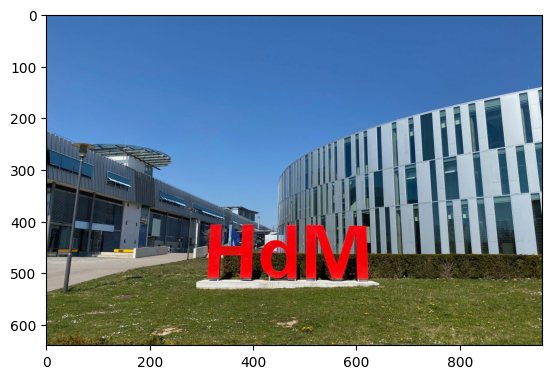

In [4]:
image = cv2.imread('./sample_imgs/hdm.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image);

### 1. Point Prompt

In [5]:
from segment_anything import sam_model_registry, SamPredictor

**Load SAM model checkpoint and set device to CUDA**

In [8]:
used_model = "vit_h"
sam = sam_model_registry[used_model](checkpoint=os.path.join(model_folder_path, model_file_names[used_model]))
sam.to(device="cuda")

predictor = SamPredictor(sam)

**Creating image embedding**

In [9]:
predictor.set_image(image)

**Creating Point Prompt**

In [33]:
input_point = np.array([[390, 450]])
input_label = np.array([1])  #  labels 1 (foreground point) or 0 (background point)

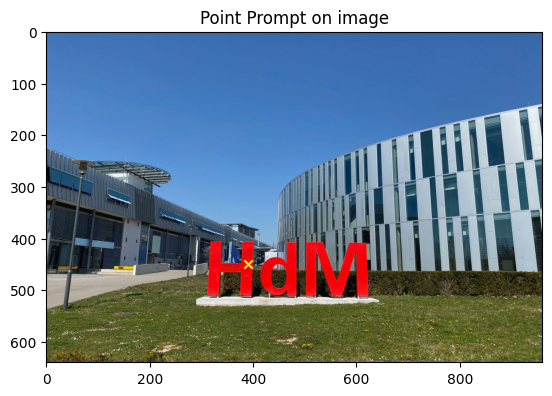

In [70]:
plt.imshow(image)
plt.scatter(input_point[0, 0], input_point[0, 1], marker="x", color="yellow")
plt.title("Point Prompt on image")
plt.show();

**Mask Prediction**

In [35]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

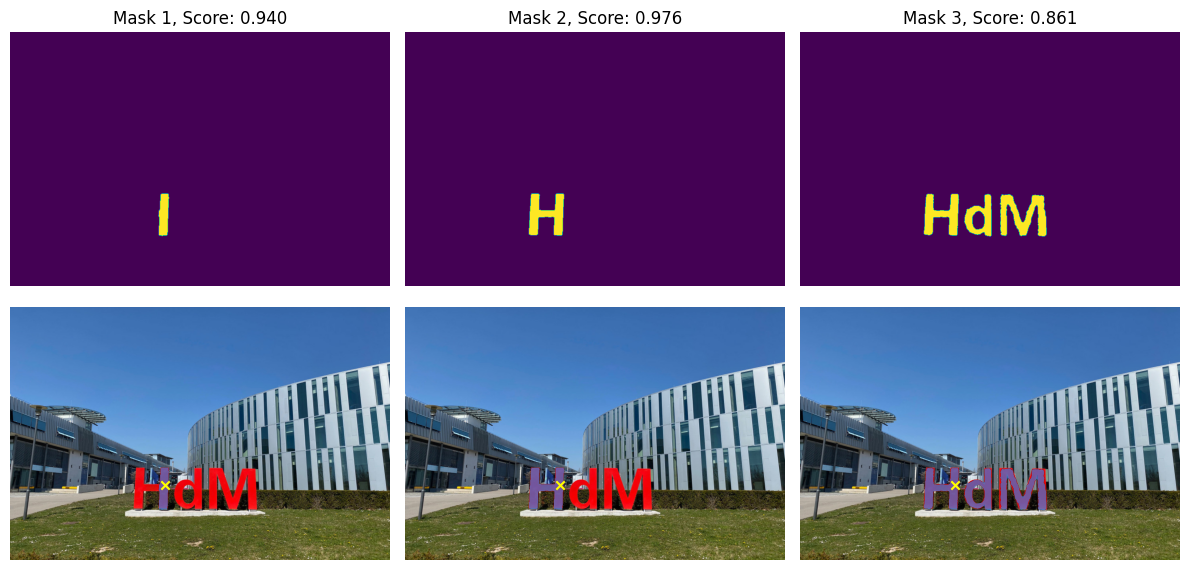

In [80]:
color = np.array([30/255, 144/255, 255/255, 0.6])
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, (mask, score) in enumerate(zip(masks, scores)):
    axs[0, i].set_title(f"Mask {i+1}, Score: {score:.3f}")
    axs[0, i].imshow(mask)
    axs[0, i].axis('off')
    
    axs[1, i].imshow(image)
    axs[1, i].scatter(input_point[0, 0], input_point[0, 1], marker="x", color="yellow")
    axs[1, i].imshow(mask.reshape(mask.shape[0], mask.shape[1], -1) * color.reshape(1, 1, -1))
    axs[1, i].axis('off')
    
fig.tight_layout()
plt.show();

In [73]:
input_point = np.array([[390, 450], [600, 425]])
input_label = np.array([1, 1])  #  labels 1 (foreground point) or 0 (background point)

In [81]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

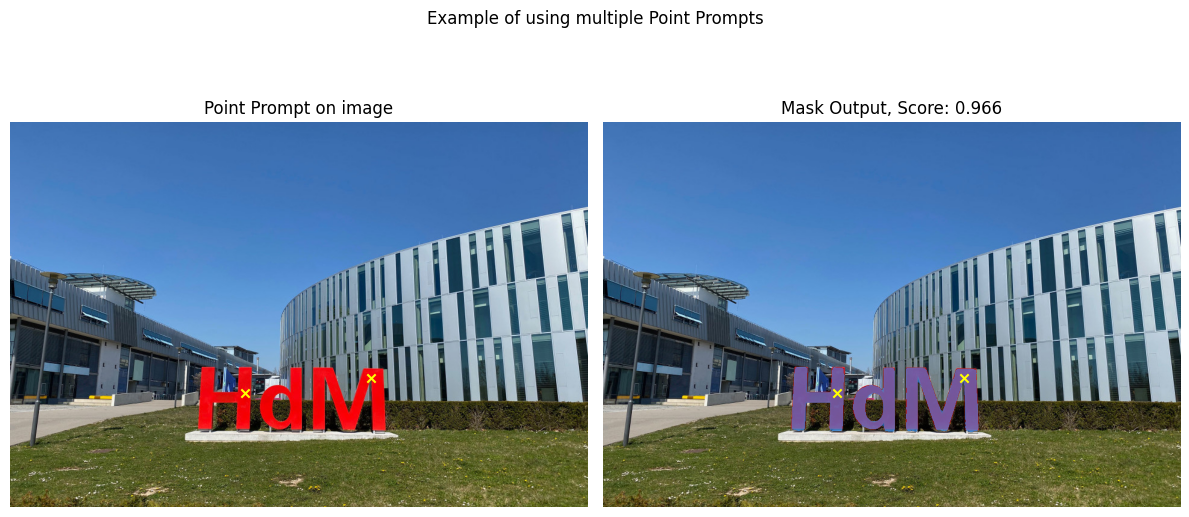

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title("Point Prompt on image")
axs[0].imshow(image)
axs[0].scatter(input_point[0, 0], input_point[0, 1], marker="x", color="yellow")
axs[0].scatter(input_point[1, 0], input_point[1, 1], marker="x", color="yellow")
axs[0].axis('off')

axs[1].set_title(f"Mask Output, Score: {scores[0]:.3f}")
axs[1].imshow(image)
axs[1].scatter(input_point[0, 0], input_point[0, 1], marker="x", color="yellow")
axs[1].scatter(input_point[1, 0], input_point[1, 1], marker="x", color="yellow")
axs[1].imshow(masks[0].reshape(masks[0].shape[0], masks[0].shape[1], -1) * color.reshape(1, 1, -1))
axs[1].axis('off')

fig.suptitle("Example of using multiple Point Prompts")
fig.tight_layout()
plt.show()